In [1]:
options(warn = -1, tidyverse.quiet = T)

library(tidyverse, warn.conflicts = F, quietly = T)
library(arrow, warn.conflicts = F)
library(cowplot, warn.conflicts = F)
library(yardstick, warn.conflicts = F)
suppressPackageStartupMessages(library(ggmanh, warn.conflicts = F))
suppressPackageStartupMessages(library(hudson, warn.conflicts = F))
library(scattermore)

# Load data

In [2]:
raw_comparison_df <- read_parquet("data/gwas_comparison.parquet") %>%
    mutate(
        chromosome = ID %>% 
            str_extract("^.+(?=:)") %>% 
            as.double %>% 
            factor(levels = c(1:22)),
        position = ID %>% str_extract("(?<=:).+$") %>% as.double,
    )

raw_comparison_df %>% head(2)

ID,P_ref,truth,phenotype_id,P,estimate,chromosome,position
<chr>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
1:752566,0.6773,FALSE,MaxGCP (N=350k),0.846883,FALSE,1,752566
1:752566,0.6773,FALSE,MaxGCP (N=15k),0.970411,FALSE,1,752566


In [3]:
t2d_df <- read_tsv(
        "data/gwas/naive.b_E11.glm.linear", col_select = c("#CHROM", "POS", "P"), 
        show_col_types = F
    ) %>%
    rename(CHROM = `#CHROM`)

t2d_df %>% head(2)

CHROM,POS,P
<dbl>,<dbl>,<dbl>
1,752566,0.983195
1,752721,0.975430


# Manhattan plots

In [4]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

ref_plot <- raw_comparison_df %>%
    filter(phenotype_id == "MaxGCP (N=350k)") %>%
    manhattan_plot(pval.colname = "P_ref", chr.colname = "chromosome", pos.colname = "position")

maxgcp_full_plot <- raw_comparison_df %>%
    filter(phenotype_id == "MaxGCP (N=350k)") %>%
    manhattan_plot(pval.colname = "P", chr.colname = "chromosome", pos.colname = "position")

naive_full_plot <- raw_comparison_df %>%
    filter(phenotype_id == "Naive (N=350k)") %>%
    manhattan_plot(pval.colname = "P", chr.colname = "chromosome", pos.colname = "position")

t2d_plot <- t2d_df %>%
    manhattan_plot(pval.colname = "P", chr.colname = "CHROM", pos.colname = "POS")

Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.
Coordinate system already present. Adding new coordinate system, which will replace the existing one.


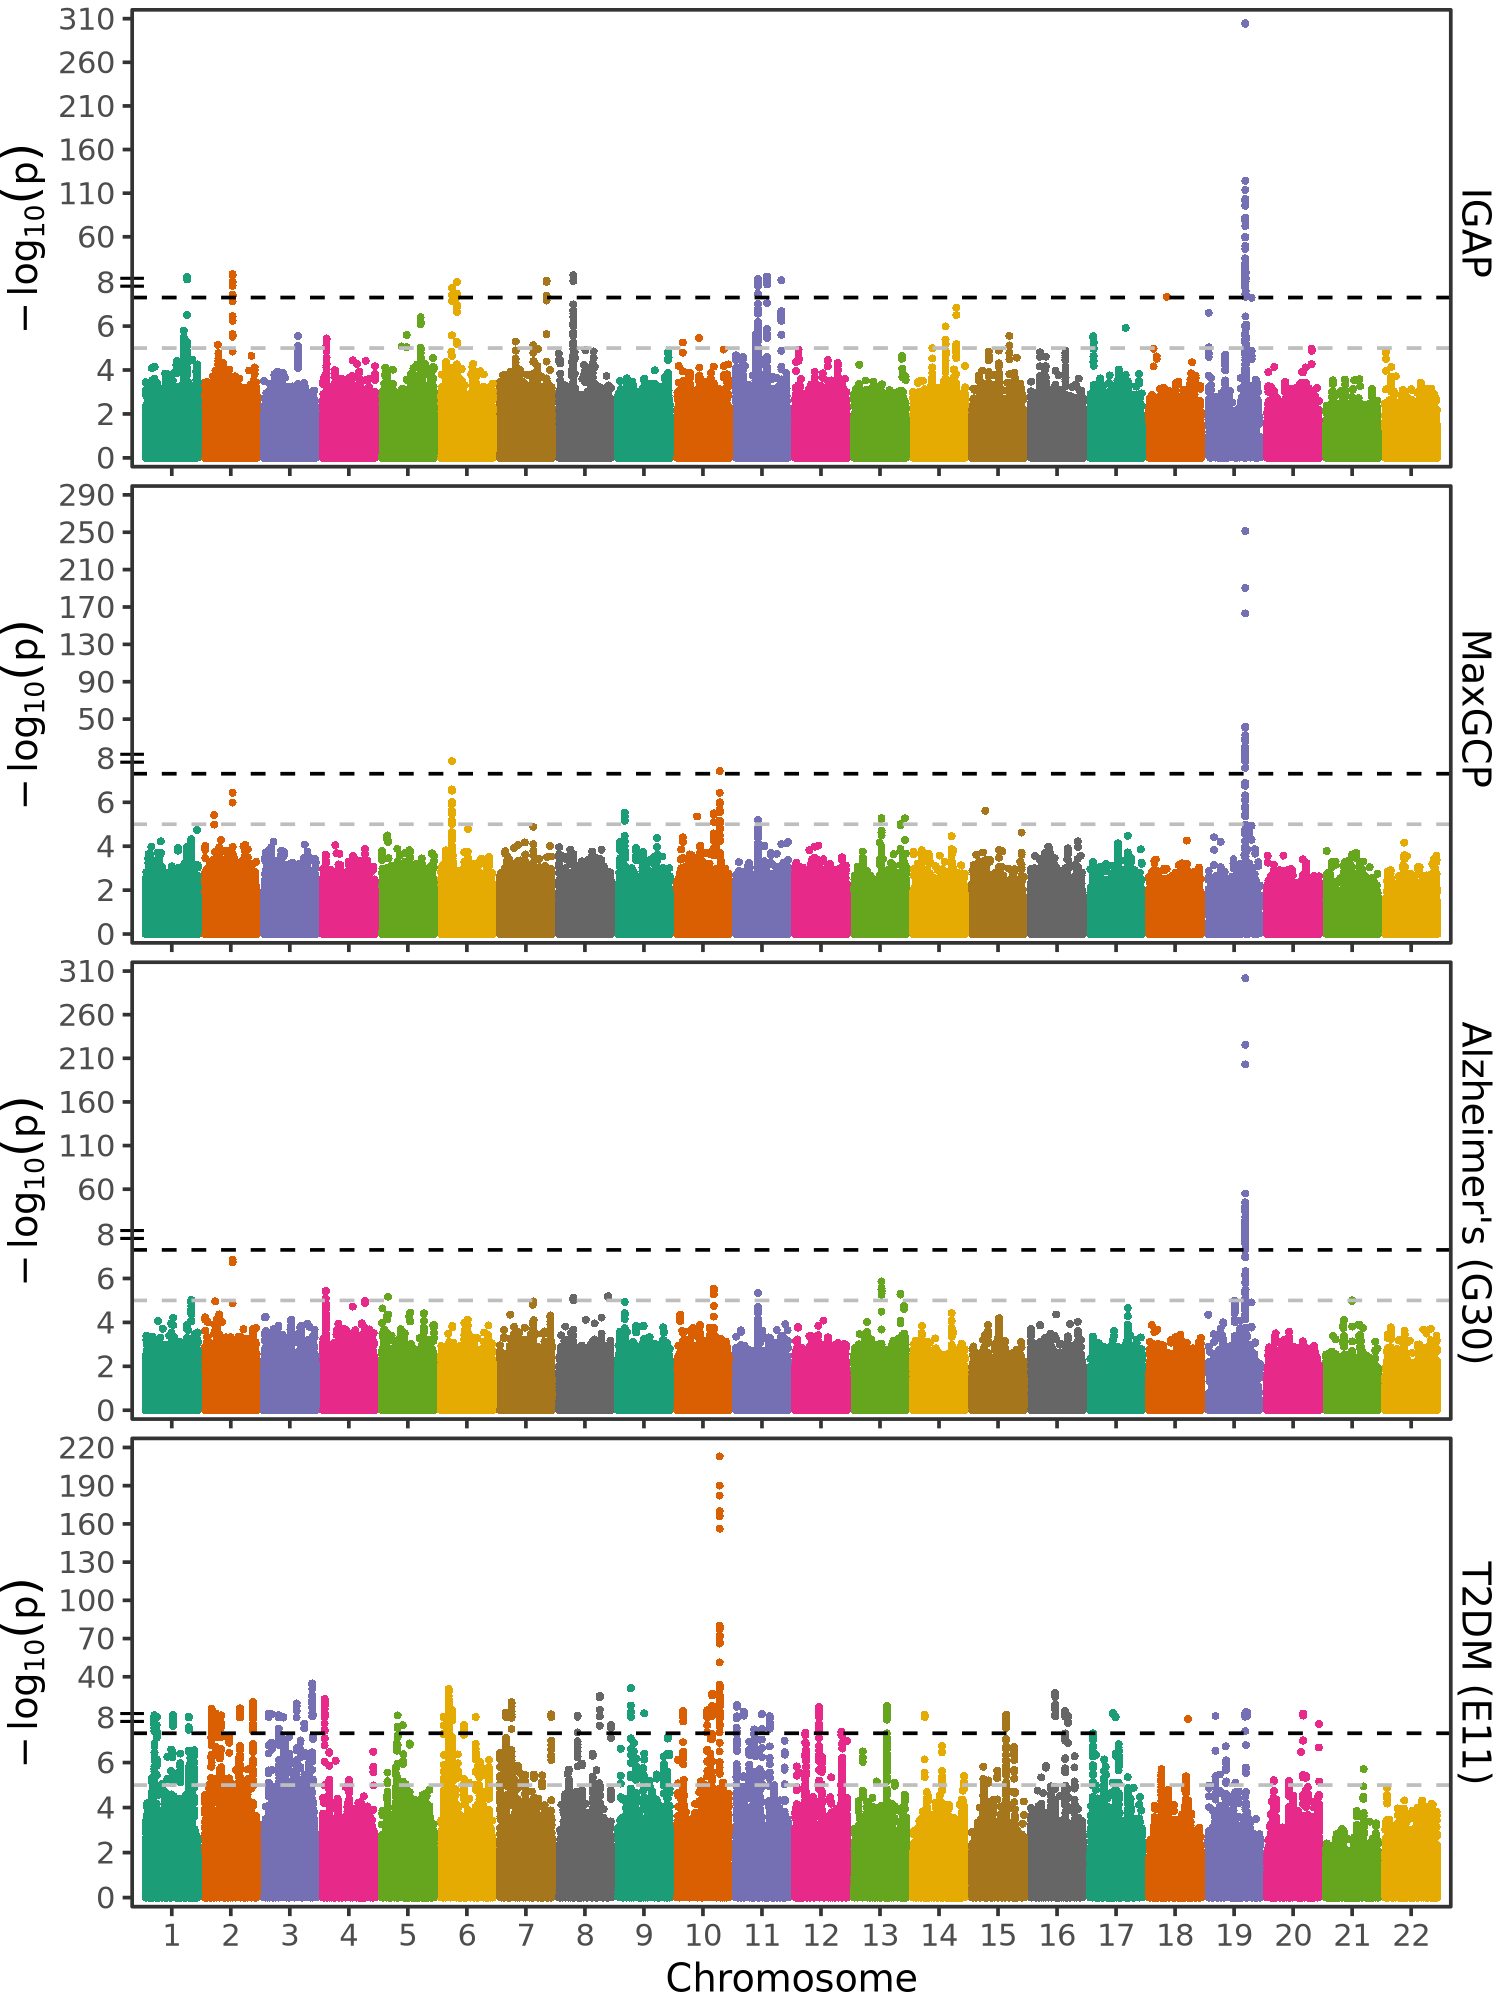

In [5]:
options(repr.plot.width = 6, repr.plot.height = 8, repr.plot.res = 250)

combined_manhattan_plot <- plot_grid(
    ref_plot +
        annotate(geom = "text", x = Inf, y = 0, angle = 270, hjust = 3, vjust = -0.4, 
                 label = "IGAP") +
        coord_cartesian(clip = "off") +
        theme(
            axis.text.x = element_blank(),
            axis.title.x = element_blank(),
            plot.margin = margin(0.1, 0.5, 0, 0, "cm")
        ),
    maxgcp_full_plot +
        annotate(geom = "text", x = Inf, y = 0, angle = 270, hjust = 1.92, vjust = -0.4, 
                 label = "MaxGCP") +
        coord_cartesian(clip = "off") +
        theme(
            axis.text.x = element_blank(),
            axis.title.x = element_blank(),
            plot.margin = margin(0.1, 0.5, 0, 0, "cm")
        ),
    naive_full_plot +
        annotate(geom = "text", x = Inf, y = 0, angle = 270, hjust = 1.13, vjust = -0.4, 
                 label = "Alzheimer's (G30)") +
        coord_cartesian(clip = "off") +
        theme(
            axis.text.x = element_blank(),
            axis.title.x = element_blank(),
            plot.margin = margin(0.1, 0.5, 0, 0, "cm")
        ),
    t2d_plot +
        annotate(geom = "text", x = Inf, y = 0, angle = 270, hjust = 1.5, vjust = -0.4, 
                 label = "T2DM (E11)") +
        coord_cartesian(clip = "off") +
        theme(
            plot.margin = margin(0.1, 0.5, 0, 0, "cm")
        ),
    align = "v",
    ncol = 1,
    rel_heights = c(1, 1, 1, 1.2)
)

save_plot("img/combined_manhattan.png", combined_manhattan_plot, base_height = 8, base_width = 6, 
          dpi = 400, bg = "white")

combined_manhattan_plot

# P-values vs P-values directly

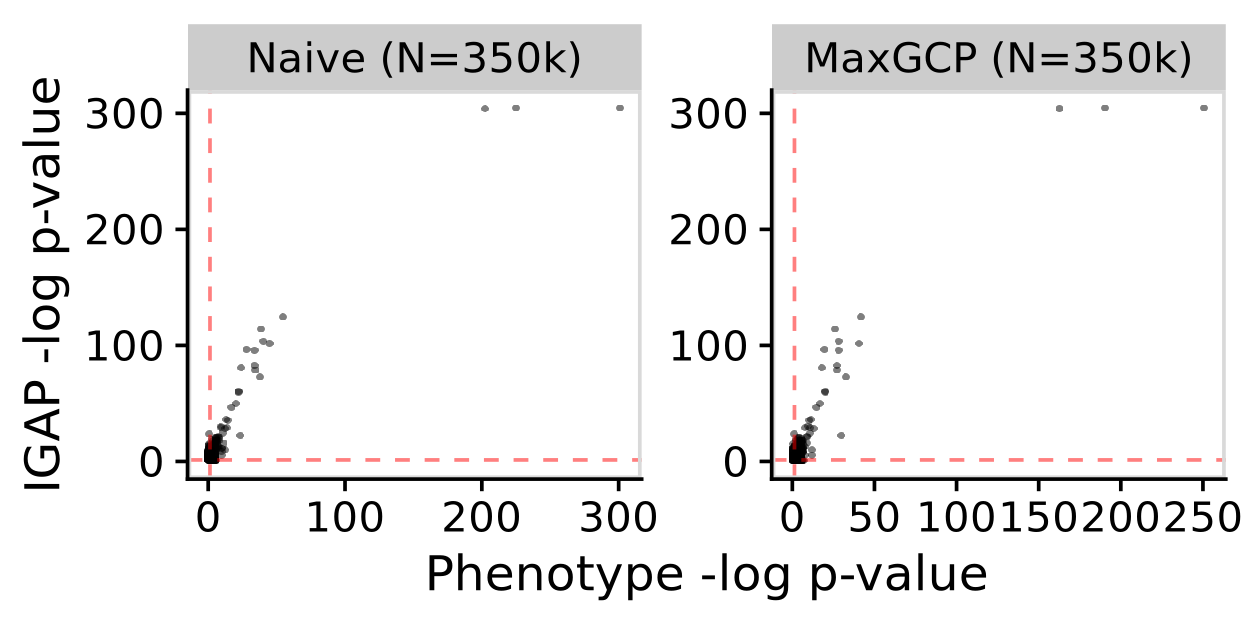

In [6]:
options(repr.plot.width = 5, repr.plot.height = 2.5, repr.plot.res = 250)

raw_comparison_df %>%
    filter(phenotype_id %>% str_detect("350")) %>%
    mutate(
        across(c(P, P_ref), ~-log10(.)),
        phenotype_id = phenotype_id %>%
            factor(levels = c("Naive (N=350k)", "MaxGCP (N=350k)"))
    ) %>%
    ggplot(aes(x = P, y = P_ref)) +
    geom_scattermore(alpha = 0.5, pointsize = 5) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", alpha = 0.5) +
    geom_vline(xintercept = -log10(0.05), linetype = "dashed", color = "red", alpha = 0.5) +
    facet_wrap(vars(phenotype_id), scales = "free") +
    theme_cowplot() +
    panel_border() +
    theme() +
    xlab("Phenotype -log p-value") +
    ylab("IGAP -log p-value")